# Propensity Model

Propensity model to target customers selling XYZ products.

In [3]:
import pandas as pd
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
from sqlalchemy import create_engine
from functools import reduce
import time
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from statsmodels.stats import proportion
import xgboost as xgb
import datetime
from datetime import timedelta 
from dateutil.relativedelta import relativedelta
from sklearn.pipeline import Pipeline, make_pipeline
sns.set_style('whitegrid')
sns.set()
%matplotlib inline
import pickle
from custom_transformers import *
from WOE import *
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import inspect
from src.tuning import *



In [4]:
from src.misc import check_jupyterlab_version
required_jl_version = "4.4"
check_jupyterlab_version(required_jl_version)

Current IM jupyterlab version (5.7) meets requirements (4.4)


## Get Data

In [5]:
def ExtractData(ListOfEffectiveDates, conn_1056):
    
    def GetDataFromSQL(SQL,SQLServer):
        conn , DF = None, None
        try:
            conn = pyodbc.connect(SQLServer, autocommit=True)
            DF = pd.io.sql.read_sql(SQL, conn)
        except Exception as ex:
            print(ex, "\n")
        finally:
            if conn is not None:
                conn.close()
        return DF
    
    def BuildTarget(TargetStartDate,TargetEndDate):
        SQL = """
        
        
        -- Confidential
        """
        try:
            TargetDF = pd.io.sql.read_sql(SQL.replace("DATE1",TargetStartDate.strftime('%Y%m%d')).replace("DATE2",TargetEndDate.strftime('%Y%m%d')), conn_1056)
            return TargetDF
        except Exception as ex:
            print(ex, "\n")
            conn_1056.close()
    
    def BuildModellingUniverse(UniverseStartDate,UniverseEndDate):
        SQL = """
        
        
        -- Confidential
        
        """
        try:
            ModellingUniverse = pd.io.sql.read_sql(SQL.replace("DATE1",UniverseStartDate.strftime('%Y%m%d')).replace("DATE2",UniverseEndDate.strftime('%Y%m%d')), conn_1056)
            #Apply the modelling universe selection inside the BuildModellingUniverse function
            ModellingUniverse = ModellingUniverse[ModellingUniverse["Modelling"]==0]
            return ModellingUniverse
        except Exception as ex:
            print(ex, "\n")
            conn_1056.close()
    
    def BuildFeatures(UniverseStartDate,UniverseEndDate):
        SQL = """
        
        
        -- Confidential
        
        
        """
        try:
            Features = pd.io.sql.read_sql(SQL.replace("DATE1",UniverseStartDate.strftime('%Y%m%d')).replace("DATE2",UniverseEndDate.strftime('%Y%m%d')), conn_1056)
            return Features
        except Exception as ex:
            print(ex, "\n")
            conn_1056.close()
    
    def BuildSlsMgrFeatures():
        SQL = """
        
        -- Confidential
        
        """
        try:
            slsmgr = pd.io.sql.read_sql(SQL, conn_1056)
            return slsmgr
        except Exception as ex:
            print(ex, "\n")
            conn_1056.close()
            
    def BuildDNBFeatures():
        SQL = """
        
        -- Confidential
        
        """
        try:
            dnb = pd.io.sql.read_sql(SQL, conn_1056)
            return dnb
        except Exception as ex:
            print(ex, "\n")
            conn_1056.close()
    
    def BuildDataset(EffectiveDate):
        #EffectiveDate is the day before the beginning of the Target period (day of scoring)
        UniverseStartDate = EffectiveDate - relativedelta(years=1)
        UniverseEndDate = EffectiveDate - timedelta(days=1)
        TargetStartDate = EffectiveDate + timedelta(days=1)
        TargetEndDate =  EffectiveDate + relativedelta(months=1)
        print("Target Period starts on   "+str(TargetStartDate))
        print("Target Period ends on     "+str(TargetEndDate))
        print("Universe Period starts on "+str(UniverseStartDate))
        print("Universe Period ends on   "+str(UniverseEndDate))
        start = time.time()
        ModellingUniverse = BuildModellingUniverse(UniverseStartDate,UniverseEndDate)
        Features = BuildFeatures(UniverseStartDate,UniverseEndDate)
        SalesMgr = BuildSlsMgrFeatures()
        DNB = BuildDNBFeatures()
        Target = BuildTarget(TargetStartDate,TargetEndDate)
        DatasetDF = pd.merge(ModellingUniverse, Features, on=["MBCN"], how='left')
        DatasetDF = pd.merge(DatasetDF, SalesMgr, on='MBCN', how='left')
        DatasetDF = pd.merge(DatasetDF, DNB, on="MBCN", how='left')
        DatasetDF = pd.merge(DatasetDF, Target, on=["MBCN"], how='left')
        DatasetDF["Target"] = DatasetDF["Target"].fillna(0)
        end = time.time()
        print(f'modelling_universe took {end-start} seconds')
        print("--------------------------------------------")
        return DatasetDF
    
    if len(ListOfEffectiveDates) > 1:
        ListOfDF = list(map(lambda x:BuildDataset(x),ListOfEffectiveDates))
        Dataset = pd.concat(ListOfDF).reset_index(drop=True)
        # cast to numeric type if possible
        Dataset = Dataset.apply(pd.to_numeric, errors='ignore')
        Dataset['PRODUCT_CLASS_X'] = Dataset['PRODUCT_CLASS_X'].astype(str)
        # Remove all nan columns
        Dataset = Dataset.dropna(axis=1, how='all')
        # Remove columns with the same value
        nunique = Dataset.apply(pd.Series.nunique)
        cols_to_drop = nunique[nunique == 1].index
        Dataset = Dataset.drop(cols_to_drop, axis=1)
        return Dataset
    elif len(ListOfEffectiveDates) == 1:
        # Not dropping all nan/single valued columns in the scoring
        # phase, to prevent the rare case of dropping one of the
        # selected features. It's OK if we have some extra columns
        # in the scoring set.
        Dataset = BuildDataset(ListOfEffectiveDates[0])
        Dataset = Dataset.apply(pd.to_numeric, errors='ignore')
        Dataset['PRODUCT_CLASS_X'] = Dataset['PRODUCT_CLASS_X'].astype(str)
        return Dataset

In [6]:
# The value for “START” must be <= (today’s date – one month)
# START = datetime.datetime.today().date() - relativedelta(months=1)
START = datetime.datetime.strptime('2023-06-01', '%Y-%m-%d').date()

In [7]:
DATE_LST = [START - relativedelta(months=i) for i in range(12)]

In [8]:
#Extract data over multiple time period to build a larger datasets (advice to extract 12 or 24 months)
conn_1056 = pyodbc.connect("DSN=1056d", autocommit=True)
Dataset = ExtractData(DATE_LST, conn_1056)
conn_1056.close()

Target Period starts on   2023-06-02
Target Period ends on     2023-07-01
Universe Period starts on 2022-06-01
Universe Period ends on   2023-05-31


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 408.759938955307 seconds
--------------------------------------------
Target Period starts on   2023-05-02
Target Period ends on     2023-06-01
Universe Period starts on 2022-05-01
Universe Period ends on   2023-04-30


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 834.5403385162354 seconds
--------------------------------------------
Target Period starts on   2023-04-02
Target Period ends on     2023-05-01
Universe Period starts on 2022-04-01
Universe Period ends on   2023-03-31


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 860.1302766799927 seconds
--------------------------------------------
Target Period starts on   2023-03-02
Target Period ends on     2023-04-01
Universe Period starts on 2022-03-01
Universe Period ends on   2023-02-28


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 335.3895421028137 seconds
--------------------------------------------
Target Period starts on   2023-02-02
Target Period ends on     2023-03-01
Universe Period starts on 2022-02-01
Universe Period ends on   2023-01-31


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 249.94861769676208 seconds
--------------------------------------------
Target Period starts on   2023-01-02
Target Period ends on     2023-02-01
Universe Period starts on 2022-01-01
Universe Period ends on   2022-12-31


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 253.20428776741028 seconds
--------------------------------------------
Target Period starts on   2022-12-02
Target Period ends on     2023-01-01
Universe Period starts on 2021-12-01
Universe Period ends on   2022-11-30


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 206.06566619873047 seconds
--------------------------------------------
Target Period starts on   2022-11-02
Target Period ends on     2022-12-01
Universe Period starts on 2021-11-01
Universe Period ends on   2022-10-31


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 219.13412761688232 seconds
--------------------------------------------
Target Period starts on   2022-10-02
Target Period ends on     2022-11-01
Universe Period starts on 2021-10-01
Universe Period ends on   2022-09-30


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 233.77962017059326 seconds
--------------------------------------------
Target Period starts on   2022-09-02
Target Period ends on     2022-10-01
Universe Period starts on 2021-09-01
Universe Period ends on   2022-08-31


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 218.5975730419159 seconds
--------------------------------------------
Target Period starts on   2022-08-02
Target Period ends on     2022-09-01
Universe Period starts on 2021-08-01
Universe Period ends on   2022-07-31


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 269.4521391391754 seconds
--------------------------------------------
Target Period starts on   2022-07-02
Target Period ends on     2022-08-01
Universe Period starts on 2021-07-01
Universe Period ends on   2022-06-30


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 276.3313479423523 seconds
--------------------------------------------


In [9]:
Dataset.isnull().sum()

MBCN                          0
DAYS_SINCE_LASTINVOICE        0
EXTENDEDSALES_12M             0
HPE_SALES                     0
DELL_SALES                    0
                          ...  
SalesManagerCd               12
SICDIVISION               17184
EMPLOYEESTOTALFINALBIN    17184
ANSALESCR                 21887
Target                        0
Length: 80, dtype: int64

In [10]:
total_records = Dataset.shape[0]
total_positive_records = Dataset['Target'].sum()
total_response_rate = total_positive_records/total_records
print(f"total records = {total_records:,}")
print(f"total positive records = {total_positive_records:,}")
print(f"total positive response rate = {total_response_rate:0.4g}")

total records = 193,659
total positive records = 653.0
total positive response rate = 0.003372


In [11]:
# increment this when rewriting data
dataset_version = 3
Dataset.to_pickle(f'./data/Dataset_{dataset_version}.pkl')


## Modelling

In [12]:
Dataset = pd.read_pickle(f'./data/Dataset_{dataset_version}.pkl')

### Prepare train/test set

In [13]:
train, test = train_test_split(Dataset, test_size = 0.5, random_state = 21, stratify = Dataset['Target'])
# Use all features; let xgboost decide the important features
SelectedFeatures = [c for c in Dataset.columns if c not in ['MBCN','Modelling','Target']]
Target = 'Target'
NUM_FEATS = list(filter(lambda x:x not in list(train.select_dtypes(include=['O']).columns),SelectedFeatures))
CAT_FEATS = list(filter(lambda x:x in list(train.select_dtypes(include=['O']).columns),SelectedFeatures))

X_train = train[SelectedFeatures]
y_train = train[Target]

In [14]:
train_records = train.shape[0]
train_positive_records = train[Target].sum()
train_response_rate = train_positive_records/train_records
print(f"train records = {train_records:,}")
print(f"train positive records = {train_positive_records:,}")
print(f"train positive response rate = {train_response_rate:0.4g}")

train records = 96,829
train positive records = 326.0
train positive response rate = 0.003367


## ***There are two ways for hyperparameter tuning below, only choose 1 !***
    1. Hyperopt
    2. Sequential Tuning

### Construct pipeline - Hyperopt

In [15]:
# Let xgboost determine the thresholds for continuous variables
# DFStartPipeline is just copying the original dataframe so
# we don't modify the original data
# feel free to add other steps to process the data
woe_pipeline = Pipeline([
    ('Start', DFStartPipeline()),
    ('WOE', ConvertCategoricalFeatures(Target, CAT_FEATS)),
    ('Extract', ColumnExtractor(SelectedFeatures)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

### Set up hyperopt tuning

In [16]:
# Adjust the range accordingly
space = {
    'xgb__max_depth' : hp.choice('xgb__max_depth', range(1, 4, 1)),
    'xgb__learning_rate' : hp.quniform('xgb__learning_rate', 0.03, 0.6, 0.01),
    'xgb__n_estimators' : hp.choice('xgb__n_estimators', range(2, 20, 1)),
    'xgb__gamma' : hp.quniform('xgb__gamma', 0, 5.0, 0.1),
    'xgb__min_child_weight' : hp.quniform('xgb__min_child_weight', 0, 24, 2),
    'xgb__subsample' : hp.quniform('xgb__subsample', 0.5, 1, 0.01),
    'xgb__colsample_bytree' : hp.quniform('xgb__colsample_bytree', 0.5, 1.0, 0.01)
}

def objective(space):
    woe_pipeline.set_params(**space)
    
    # Applying repeated k-Fold Cross Validation
    # Might want to adjust n_repeats
    shuffle = RepeatedStratifiedKFold(n_splits=2, n_repeats=15, random_state=11)
    score = cross_val_score(estimator=woe_pipeline, X=train[SelectedFeatures+['Target']], y=train[Target], scoring='neg_log_loss', cv=shuffle)

    return{'loss':1-(score.mean()-2*score.std()), 'status': STATUS_OK}


# The Trials object will store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
# Might want to adjust max_evals
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

  3%|▎         | 1/30 [01:03<30:27, 63.02s/trial, best loss: 1.0215087424683147]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

  7%|▋         | 2/30 [01:50<25:03, 53.70s/trial, best loss: 1.0215087424683147]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 10%|█         | 3/30 [02:26<20:37, 45.85s/trial, best loss: 1.0215087424683147]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 13%|█▎        | 4/30 [03:14<20:12, 46.64s/trial, best loss: 1.0215087424683147]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 17%|█▋        | 5/30 [03:58<19:05, 45.82s/trial, best loss: 1.0215087424683147]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 20%|██        | 6/30 [04:43<18:06, 45.28s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 23%|██▎       | 7/30 [05:26<17:05, 44.57s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 27%|██▋       | 8/30 [06:32<18:55, 51.60s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 30%|███       | 9/30 [07:15<17:07, 48.94s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 33%|███▎      | 10/30 [08:11<16:57, 50.87s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 37%|███▋      | 11/30 [08:50<14:59, 47.35s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 40%|████      | 12/30 [09:23<12:55, 43.10s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 43%|████▎     | 13/30 [10:05<12:06, 42.71s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 47%|████▋     | 14/30 [10:48<11:24, 42.81s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 50%|█████     | 15/30 [11:35<11:00, 44.06s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 53%|█████▎    | 16/30 [12:12<09:45, 41.82s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 57%|█████▋    | 17/30 [12:49<08:45, 40.43s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 60%|██████    | 18/30 [13:26<07:53, 39.48s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 63%|██████▎   | 19/30 [14:00<06:55, 37.81s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 67%|██████▋   | 20/30 [14:41<06:28, 38.84s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 70%|███████   | 21/30 [15:16<05:37, 37.55s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 73%|███████▎  | 22/30 [15:50<04:50, 36.37s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 77%|███████▋  | 23/30 [16:33<04:29, 38.53s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 80%|████████  | 24/30 [17:11<03:49, 38.23s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 83%|████████▎ | 25/30 [17:42<03:01, 36.24s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 87%|████████▋ | 26/30 [18:12<02:17, 34.35s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 90%|█████████ | 27/30 [18:45<01:41, 33.87s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 93%|█████████▎| 28/30 [19:17<01:06, 33.23s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

 97%|█████████▋| 29/30 [19:50<00:33, 33.33s/trial, best loss: 1.0214452587684486]

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is

100%|██████████| 30/30 [20:25<00:00, 40.85s/trial, best loss: 1.0214452587684486]


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



In [17]:
from hyperopt import space_eval

# Get the values of the optimal parameters
# Need to use this function: space_eval
best_params = space_eval(space, best)
best_params

{'xgb__colsample_bytree': 0.87,
 'xgb__gamma': 0.4,
 'xgb__learning_rate': 0.4,
 'xgb__max_depth': 1,
 'xgb__min_child_weight': 2.0,
 'xgb__n_estimators': 16,
 'xgb__subsample': 0.96}

In [18]:
woe_pipeline.set_params(**best_params)
woe_pipeline.fit(train, train[Target]);

# Score data
train2 = train.copy()
y_pred_train = woe_pipeline.predict_proba(train2)[:,1]
train2['Prob'] = y_pred_train
auc_score = roc_auc_score(train2[Target], y_pred_train)
print(f"Train score: {auc_score}")

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Train score: 0.7534665631361852


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


### Construct pipeline - sequential tuning
    1. XGBoost
    2. LightGBM

In [ ]:
# Feel free to adjust the search range/step size depending on model performance
# nfold - the number of folds in cross validation during hyperparameter tuning
# ntimes - the number of repeats in cross validation during hyperparameter tuning
# val_size - the fraction set aside (not used for hyperparameter tuning) to tune n_estimators in the end
# Debatable whether necessary to set aside a validation set for tuning n_estimators, or
# we can use all train data for hyperparameter tuning and just split it when tuning n_estimators
# Might want to val_size small since we don't usually have high response rate to begin with

# lgb_params = {
#     'num_leaves': [2,3,7,15,31],
#     'min_data_in_leaf': range(40,150,10),
#     'min_gain_to_split': [i/10 for i in range(11)],
#     'subsample': [i/10 for i in range(4, 11)],
#     'colsample_bytree': [i/10 for i in range(4, 11)],
#     'eta': [.3, .2, .1, .05],
#     'lambda': [0.01, 0.05, 0.1, 0.5, 1.0],
# }

# woe_pipeline = Pipeline([
#     ('Start', DFStartPipeline()),
#     ('WOE', ConvertCategoricalFeatures(Target, CAT_FEATS)),
#     ('lgb', LGBSequentialTuning(features=SelectedFeatures,
#                                 target=Target,
#                                 eval_metric='auc',
#                                 search_params=lgb_params,
#                                 nfold=5,
#                                 ntimes=5,
#                                 val_size=0.2
#                                ))
# ])

xgb_params = {
    'max_depth': range(1, 5),
    'min_child_weight': range(1, 5),
    'gamma': [i/10 for i in range(0,5)],
    'subsample': [i/10 for i in range(4, 11)],
    'colsample_bytree': [i/10 for i in range(4, 11)],
    'lambda': [0, 0.1, 0.5, 1, 5, 10],
    'eta': [.5, .3, .2, .1, .05],
    # Fixed params
    'objective': 'binary:logistic'
}

woe_pipeline = Pipeline([
    ('Start', DFStartPipeline()),
    ('WOE', ConvertCategoricalFeatures(Target, CAT_FEATS)),
    ('xgb', XGBSequentialTuning(features=SelectedFeatures,
                                target=Target,
                                eval_metric='auc',
                                search_params=xgb_params,
                                nfold=5,
                                ntimes=5,
                                val_size=0.2
                               ))
])

In [ ]:
start = time.time()
train2 = woe_pipeline.fit_transform(train)
y_pred_train = train2['Prob']
end = time.time()
print(f"Time elapsed :{(end-start)/60.:.2f} mins")

### Features with importance > 0

In [19]:
# Change the named_steps['xgb'] to named_steps['lgb'] if using LightGBM
f_imp = woe_pipeline.named_steps['xgb'].feature_importances_
model_features, model_importances = [list(x) for x in zip(*[(SelectedFeatures[i], f_imp[i]) for i in np.where(f_imp>0)[0]])]
print(model_features)


['SALES_SERVICES', 'DAYS_SINCE_SERVICES', 'DAYS_SINCE_SECURITY', 'SALES_SERVICES_WARRANTIES', 'SALES_CISCO_HARDWARE', 'DAYS_SINCE_EndUserServices', 'NUM_EU_TELESALES_12M', 'SalesManagerCd']


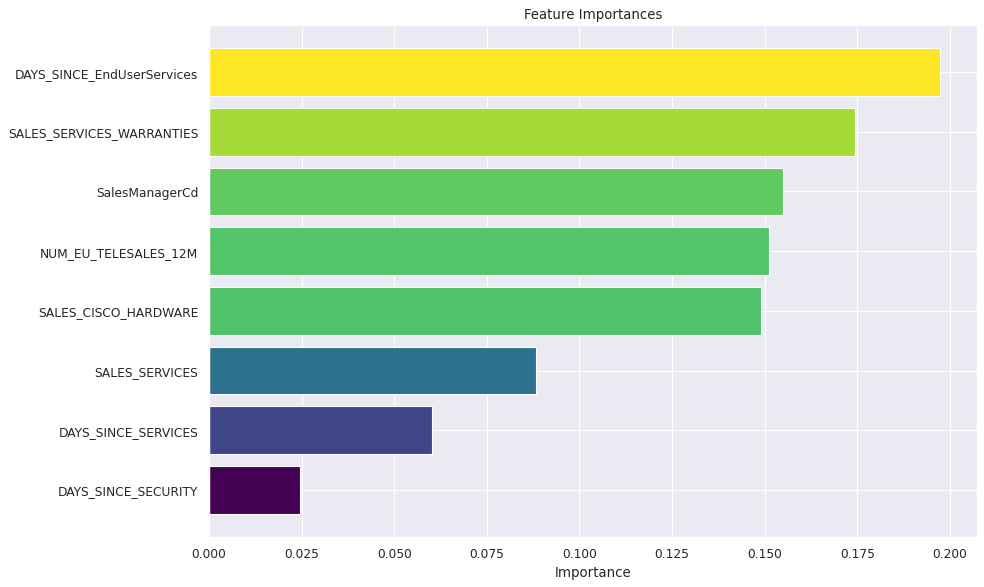

In [20]:
from src.plotting import make_feature_importance_plot
fig = make_feature_importance_plot(model_features, model_importances)
fig.savefig(f"./figs/model_feature_importances.png")
fig.show()


### Model Performance - Training Data

In [21]:
from src.plotting import make_probability_plot, make_ROC_plot, make_confusion_matrix_plot, make_precision_recall_plot

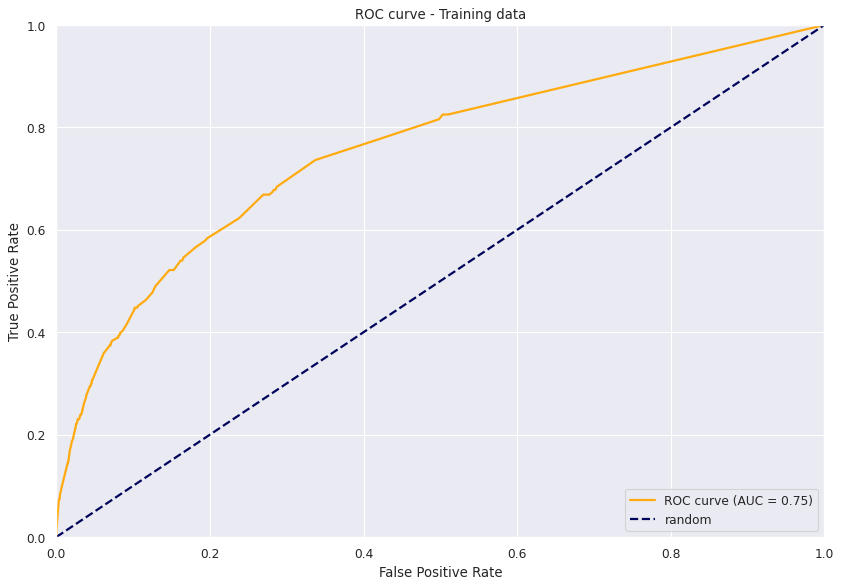

In [22]:
fig = make_ROC_plot(train2[Target], y_pred_train, title='ROC curve - Training data')
fig.savefig(f"./figs/train_ROC.png")
fig.show()

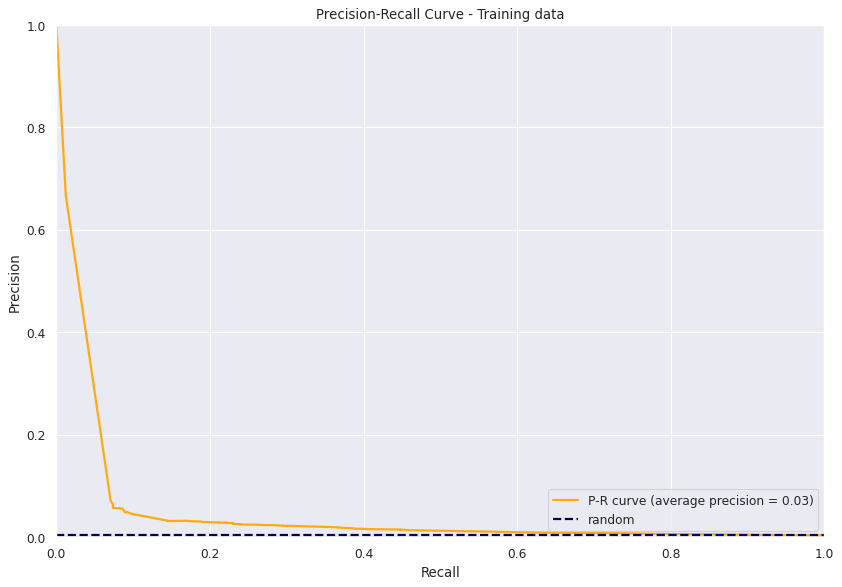

In [23]:
fig = make_precision_recall_plot(train2[Target], y_pred_train, title='Precision-Recall Curve - Training data')
fig.savefig(f"./figs/train_PR.png")
fig.show()

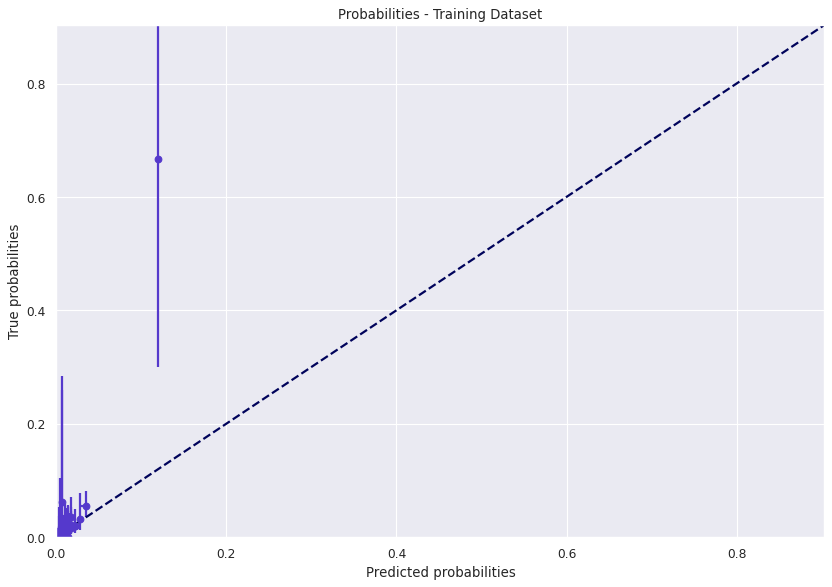

In [24]:
fig = make_probability_plot(train2, 'Target','Prob', title='Probabilities - Training Dataset', n_bins=500) 
fig.savefig(f"./figs/train_prob.png")
fig.show()


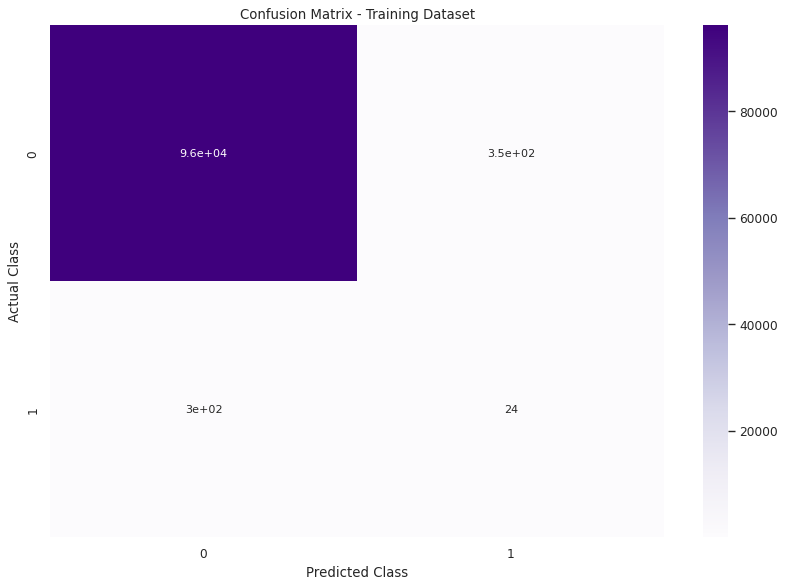

In [25]:
# estimate threshold based on true positive rate in training data
threshold = np.quantile(train2["Prob"], (1.0 -train_response_rate))
# predict labels based on above threshold
train_predicted_labels = np.where(train2["Prob"] >= threshold, 1,0)
fig = make_confusion_matrix_plot(train2['Target'],train_predicted_labels, title='Confusion Matrix - Training Dataset') 
fig.savefig(f"./figs/train_confusion_matrix.png")
fig.show()


---

### Model Performance - Test Data

#### ***hyperopt***

In [26]:
test2 = test.copy()
y_pred_test = woe_pipeline.predict_proba(test2)[:,1]
test2['Prob'] = y_pred_test
auc_score = roc_auc_score(test2[Target], y_pred_test)
print(f"Test score: {auc_score}")

Test score: 0.7376833779406519


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


#### ***sequential tuning***

In [ ]:
# If using sequential tuning
test2 = woe_pipeline.transform(test)
y_pred_test = test2['Prob']

---

### Evaluation

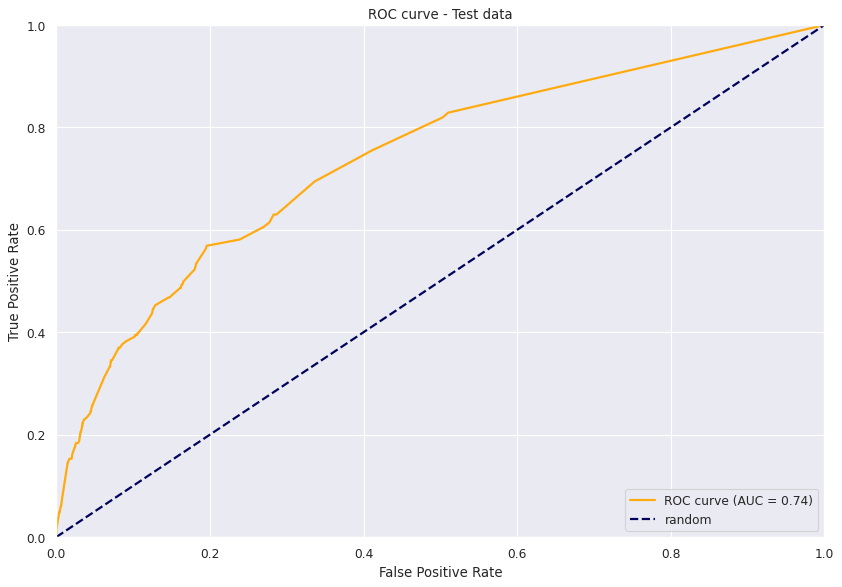

In [27]:
fig = make_ROC_plot(test2[Target], y_pred_test,  title='ROC curve - Test data')
fig.savefig(f"./figs/test_ROC.png")
fig.show()

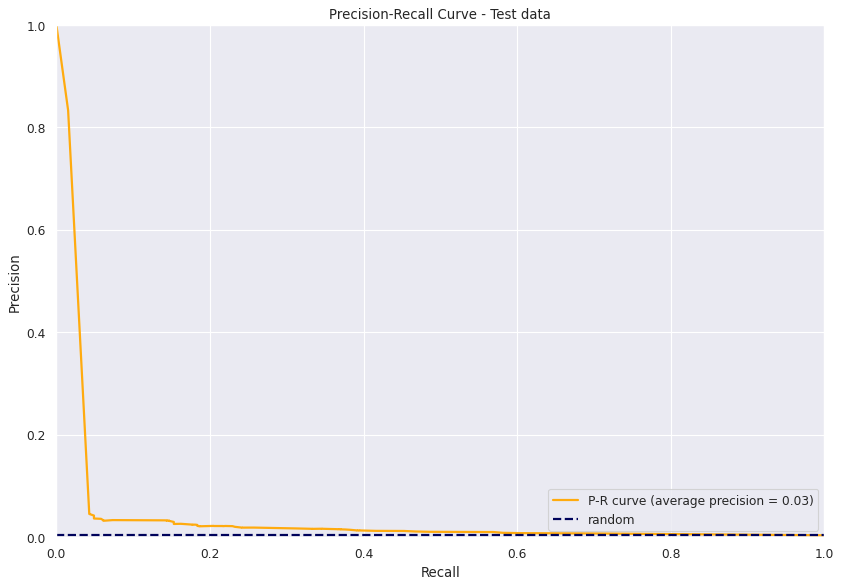

In [28]:
fig = make_precision_recall_plot(test2[Target], y_pred_test, title='Precision-Recall Curve - Test data')
fig.savefig(f"./figs/test_PR.png")
fig.show()

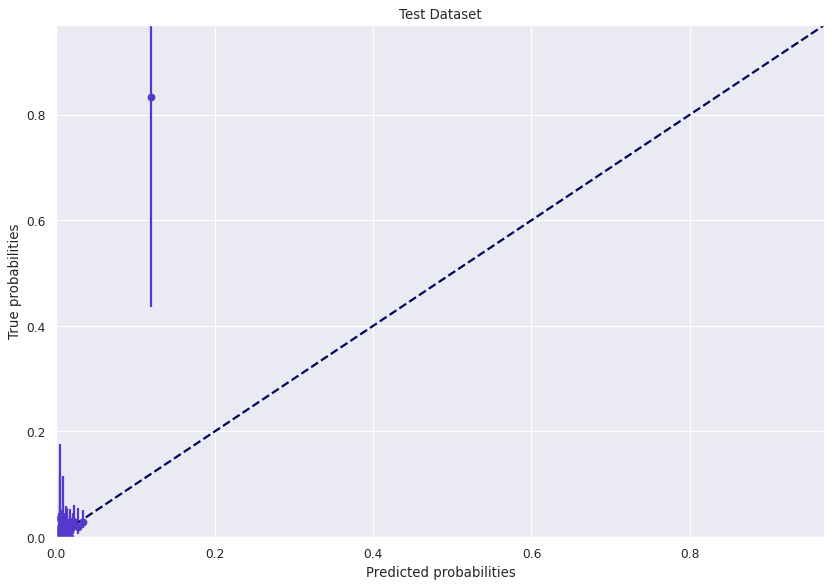

In [29]:
fig = make_probability_plot(test2,  'Target','Prob', title='Test Dataset', n_bins=500) 
fig.savefig(f"./figs/test_prob.png")
fig.show()

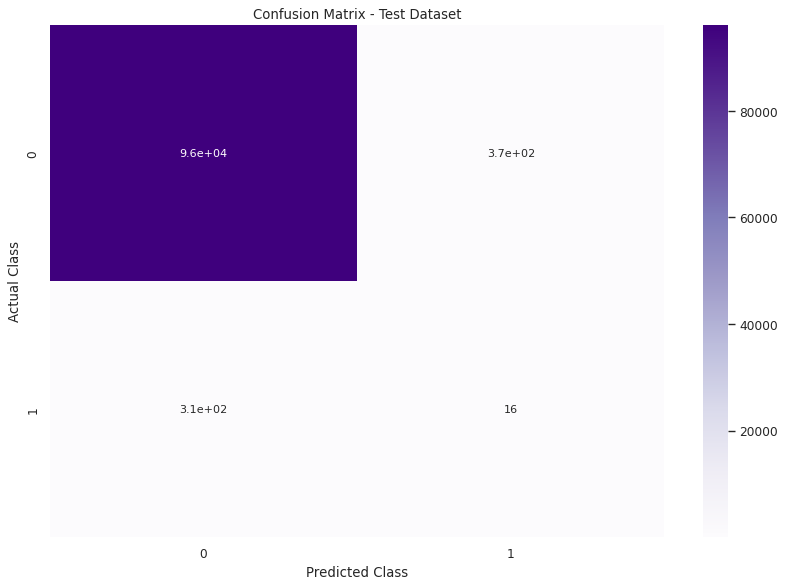

In [30]:
# use the threshold obtained from training data
# predict labels based on this threshold
test_predicted_labels = np.where(test2["Prob"] >= threshold, 1,0)
fig = make_confusion_matrix_plot(test2['Target'],test_predicted_labels, title='Confusion Matrix - Test Dataset') 
fig.savefig(f"./figs/test_confusion_matrix.png")
fig.show()

### Train with full dataset

#### ***hyperopt***

In [31]:
# Need to initialize the best model first
# Using clean names from the best_params
# The additional Column extractor is for getting the MBCN column
# otherwise we're left with only the selected features for the model
best_params_clean = {k.replace("xgb__",""):v for k, v in best_params.items()}
best_params_clean['use_label_encoder'] = False
best_params_clean['eval_metric'] = 'logloss'
final_pipeline = Pipeline([
    ('start', DFStartPipeline()),
    ('result', DFFeatureUnion([
        ('id', ColumnExtractor(['MBCN'])),
        ('model', Pipeline([
            ('WOE', ConvertCategoricalFeatures(Target, CAT_FEATS)),
            ('extract', ColumnExtractor(SelectedFeatures)),
            ('xgb', PredictProbaTransformer(xgb.XGBClassifier(**best_params_clean)))
        ]))
    ])),
    ('clean', ColumnExtractor(['MBCN','Prob','EXTENDEDSALES_12M']))
])

result_df = final_pipeline.fit_transform(Dataset, Dataset[Target])

/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


#### ***sequential tuning***

In [ ]:
# Change to lgb if using LightGBM
# lgb.LGBClassifier
# You can add columns to the ColumnExtractor to match your needs
best_params_clean = woe_pipeline.named_steps['xgb'].best_params
# Don't need these two lines if using LightGBM
best_params_clean['use_label_encoder'] = False
best_params_clean['eval_metric'] = 'logloss'
final_pipeline = Pipeline([
    ('start', DFStartPipeline()),
    ('result', DFFeatureUnion([
        ('id', ColumnExtractor(['MBCN'])),
        ('model', Pipeline([
            ('WOE', ConvertCategoricalFeatures(Target, CAT_FEATS)),
            ('extract', ColumnExtractor(SelectedFeatures)),
            ('xgb', PredictProbaTransformer(xgb.XGBClassifier(**best_params_clean)))
        ]))
    ])),
    ('clean', ColumnExtractor(['MBCN','Prob','EXTENDEDSALES_12M']))
])
result_df = final_pipeline.fit_transform(Dataset, Dataset[Target])
# Sort the results by both probability and annual sales to better order within a probability bin
# You can sort with ascending DAYS_SINCE_LAST_INVOICE as well
result_df = result_df.sort_values(by=['Prob','EXTENDEDSALES_12M'], ascending=[False,False])

In [32]:
result_df.head()

,MBCN,Prob,EXTENDEDSALES_12M
0,60816112,0.002973,241.76
1,30724810,0.002309,2747.53
2,70797102,0.002309,30570.76
3,14342781,0.009180,255998.02
4,41591972,0.002949,8303.94


### Saving pipeline and extract data function

In [33]:
# You can use pickle or joblib
# We're saving the function 'ExtractData' as a string

pipeline_version = 2
# increment this when retraining/experimenting

pickle.dump((final_pipeline, inspect.getsource(ExtractData)),open(f'./models/pipeline_v{pipeline_version}.pkl','wb'))

## Scoring

In [34]:
(final_pipeline, tmp_func) = pickle.load(open(f'./models/pipeline_v{pipeline_version}.pkl' , "rb" ))
# Creating 'ExtractData' from string
exec(tmp_func)

In [35]:
# Scoring model as of today
# Make sure you don't call fit_transform again, just transform
conn_1056 = pyodbc.connect("DSN=1056d", autocommit=True)
scoring_df = final_pipeline.transform(
                ExtractData([datetime.date.today()], conn_1056)
                )
conn_1056.close()

Target Period starts on   2023-07-08
Target Period ends on     2023-08-07
Universe Period starts on 2022-07-07
Universe Period ends on   2023-07-06


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/conda/envs/py3notebook/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connecta

modelling_universe took 170.2705054283142 seconds
--------------------------------------------


/opt/conda/envs/py3notebook/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [36]:
scoring_df = scoring_df.sort_values(by=['Prob','EXTENDEDSALES_12M'], ascending=[False,False])
scoring_df.head()

,MBCN,Prob,EXTENDEDSALES_12M
15036,30825930,0.087290,1294744.78
1603,14992672,0.064656,177794.15
5320,41443942,0.056569,99011.42
4401,30461082,0.030721,12424371.72
3549,60160731,0.030721,8752658.06


In [37]:
scoring_df.to_excel('Meraki Propensity Model Results.xlsx')

## Appendix

In [38]:
# Prepare dataset for hyperparameter tuning in Spark
spark_pipeline = Pipeline([
    ('Start', DFStartPipeline()),
    ('WOE', ConvertCategoricalFeatures(Target, CAT_FEATS)),
    ('Extract', ColumnExtractor(SelectedFeatures+['Target']))
])

train_spark = spark_pipeline.fit_transform(train)

In [39]:
train_spark.to_pickle(f'./data/spark_train_v{dataset_version}.pkl', protocol=3)